In [41]:
from tensorflow import keras
from imutils import paths
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense
from keras.applications import ResNet50
from keras.models import load_model

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os
import mediapipe as mp

In [2]:
train_dir = 'E:/군순/train'
test_dir = 'E:/군순/train'
# 비디오 파일 목록과 태그를 포함하는 리스트를 만드는 함수
def create_data_list(data_dir):
    data_list = []
    # data_dir 안의 각 디렉토리에 대해 반복
    for item in os.listdir(data_dir):
        item_path = os.path.join(data_dir, item)  # 아이템의 전체 경로
        # 해당 경로가 디렉토리인지 확인
        if os.path.isdir(item_path):
            # 디렉토리 내의 모든 파일을 나열
            for file_name in os.listdir(item_path):
                # 파일이 .mp4 파일인지 확인
                if file_name.endswith('.mp4'):
                    # 리스트에 태그와 파일 경로를 추가
                    data_list.append((item, str('E:/군순/train'+'/'+item)+'/'+file_name))
    return data_list

# 함수를 사용해서 리스트를 생성
train_list = create_data_list(train_dir)
test_list = create_data_list(test_dir)
# 리스트에서 데이터프레임을 생성
train_df = pd.DataFrame(data=train_list, columns=['tag', 'video_name'])
test_df = pd.DataFrame(data=test_list, columns=['tag', 'video_name'])
# 필요한 경우 열 순서를 수정
train_df = train_df.loc[:, ['tag', 'video_name']]
test_df = test_df.loc[:, ['tag', 'video_name']]
# 데이터프레임을 CSV 파일로 저장
train_file_path = 'train.csv'
test_file_path = 'test.csv'
train_df.to_csv(train_file_path, encoding='utf-8-sig', index=False)
test_df.to_csv(test_file_path, encoding='utf-8-sig', index=False)

In [3]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
print(f"Total video for training: {len(train_df)}")
print(f"Total video for testing: {len(test_df)}")

Total video for training: 75
Total video for testing: 75


In [4]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 100

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048
SKELETON_FEATURES = 33*4
HAND_FEATURES = 21*3*2

In [5]:
# 라벨링
label_processor = keras.layers.StringLookup(num_oov_indices=0, vocabulary=np.unique(train_df["tag"]))
labels = train_df["tag"].values
labels = label_processor(labels[..., None]).numpy()

In [6]:
# 주어진 이미지에서 중앙에 맞춰 정사각형으로 잘나내는 함수
def crop_center_square(frame):
    # 이미지의 높이(y)와 너비(x)를 가져옴
    y, x = frame.shape[0:2]
    # 이미지의 높이와 너비 중 더 작은 값을 선택하여 정사각형의 크기를 결정
    min_dim = min(y, x)
    # 정사각형을 이미지 중앙에 위치시키기 위해 시작점의 x좌표와 y좌표를 계산
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    # 계산된 시작점과 정사각형의 크기를 이용하여 이미지의 중앙 부분을 잘라냅니다.
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

In [7]:
# 비디오 파일을 로드하고, 각 프레임을 처리하여 배열로 반환하는 함수
def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    mp_hands = mp.solutions.hands
    mp_pose = mp.solutions.pose

    pose = mp_pose.Pose(static_image_mode=False, model_complexity=1, smooth_landmarks=True)
    hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)
    # OpenCV를 사용하여 비디오 파일 열기
    cap = cv2.VideoCapture(path)
    frames = []
    skeletons = []  # 스켈레톤 데이터
    hand_landmarks = []  # 손 데이터

    try:
        while True:
            # 비디오에서 프레임을 하나씩 읽기
            ret, frame = cap.read()
            # 읽을 프레임이 없으면 반복문을 종료
            if not ret:
                break
            # 읽은 프레임에서 중앙의 정사각형 부분을 잘라냄
            frame = crop_center_square(frame)
            # 프레임의 크기를 지정된 크기로 조절
            frame = cv2.resize(frame, resize)            
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # Mediapipe를 사용하여 스켈레톤 추출
            hands_results = hands.process(frame_rgb)
            pose_results = pose.process(frame_rgb)
           
            if pose_results.pose_landmarks:
                skeletons.append(pose_results.pose_landmarks.landmark)
            if hands_results.multi_hand_landmarks:
                hand_landmarks.append(hands_results.multi_hand_landmarks)
            
            # OpenCV는 BGR 색상 순서를 사용하므로, 이를 RGB 순서로 변경
            frame = frame[:, :, [2, 1, 0]]
            # 처리된 프레임을 프레임 리스트에 추가
            frames.append(frame)
            # max_frames가 지정된 경우, 지정된 수의 프레임만큼만 처리
            if len(frames) == max_frames:
                break
    finally:
        # 비디오 파일을 닫기
        cap.release()
        pose.close
        hands.close
    return np.array(frames), skeletons, hand_landmarks

In [8]:
# 특징추출
def build_feature_extractor():
    # 이미지 특징 추출을 위한 InceptionV3 모델
    base_model = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input
    image_input = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed_image = preprocess_input(image_input)
    image_features = base_model(preprocessed_image)

    # Mediapipe 데이터를 위한 입력 레이어 및 처리 레이어
    # 예시로, Mediapipe 데이터의 차원을 상정하여 입력 레이어를 정의
    mediapipe_input = keras.Input((258,))
    mediapipe_features = keras.layers.Dense(258, activation="relu")(mediapipe_input)

    # 이미지 특징과 Mediapipe 데이터의 결합
    combined_features = keras.layers.concatenate([image_features, mediapipe_features])

    # 최종 모델
    outputs = keras.layers.Dense(15, activation="softmax")(combined_features)
    return keras.Model(inputs=[image_input, mediapipe_input], outputs=outputs, name="feature_extractor")

In [9]:
# 손 랜드마크를 2개로 제한한 코드
def preprocess_skeleton_data(skeleton):
    # 스켈레톤 데이터가 없는 경우 빈 벡터 반환
    if not skeleton:
        return np.zeros(SKELETON_FEATURES)
    # 스켈레톤 데이터를 1차원 배열로 변환
    skeleton_array = np.array([[lm.x, lm.y, lm.z] for lm in skeleton]).flatten()    
    # 부족한 부분을 0으로 채우기
    skeleton_array = np.pad(skeleton_array, ((0, max(0, SKELETON_FEATURES - len(skeleton_array)))) )    
    return skeleton_array

def preprocess_hand_data(hand_landmarks):
    # 손 랜드마크 데이터가 없는 경우 빈 벡터 반환
    if not hand_landmarks or len(hand_landmarks) < 2:
        return np.zeros(HAND_FEATURES)
    
    # 첫 번째와 두 번째 손에 대한 랜드마크만 처리
    hand_data = []
    for i in range(2):
        hand_lm = hand_landmarks[i]
        lm_array = np.array([[lm.x, lm.y, lm.z] for lm in hand_lm.landmark]).flatten()
        hand_data.extend(lm_array)

    # 부족한 부분을 0으로 채우기
    hand_data = np.pad(hand_data, ((0, max(0, HAND_FEATURES - len(hand_data)))))

    return np.array(hand_data)

def preprocess_image(frame):    
    frame = image.img_to_array(frame[0])  # frame[0]으로 변경
    frame = preprocess_input(frame)  # ResNet50의 전처리 함수를 사용하여 정규화
    return frame

In [10]:
def prepare_all_video(df):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()

    # Mediapipe 데이터를 저장할 배열 초기화
    frame_skeletons = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, SKELETON_FEATURES), dtype="float32")
    frame_hands = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, HAND_FEATURES), dtype="float32")
    
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")
    
    # 이미지 데이터 저장할 배열 초기화
    frame_images = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, IMG_SIZE, IMG_SIZE, 3), dtype="float32")
    
    # 특징 추출기 모델 초기화
    feature_extractor = build_feature_extractor()

    for idx, path in enumerate(video_paths):
        frames, skeletons, hands = load_video(path)
        video_length = min(MAX_SEQ_LENGTH, frames.shape[1])

        for i in range(video_length):
            # 이미지 데이터 전처리 및 특징 추출
            image_feature = preprocess_image(frames[i:i+1])
            image_feature = np.expand_dims(image_feature, axis=0)  # 차원 확장
            
            # InceptionV3 모델에 전처리된 이미지 전달
            image_feature = feature_extractor.layers[0](image_feature)            
            
            # Mediapipe 데이터 전처리
            skeleton_feature = preprocess_skeleton_data(skeletons[i])
            hand_feature = preprocess_hand_data(hands[i])
            combined_mediapipe_data = np.concatenate([skeleton_feature, hand_feature])
            
            # 차원 확장
            combined_mediapipe_data = np.expand_dims(combined_mediapipe_data, axis=0)
            
            # 크기 확인
            print("Image Feature shape:", image_feature.shape)
            print("Combined Mediapipe Data shape:", combined_mediapipe_data.shape)
            
            # 데이터 저장
            frame_images[idx, i, :] = image_feature           

            # Mediapipe 데이터의 전처리 및 저장
            frame_skeletons[idx, i, :] = skeleton_feature
            frame_hands[idx, i, :] = hand_feature

            frame_masks[idx, i] = 1
            
            # 모델 예측
            try:
                frame_feature = feature_extractor.predict([image_feature, combined_mediapipe_data])
                print("Prediction shape:", frame_feature.shape)
            except Exception as e:
                print("Error during prediction:", e)

    # 반환 값에 Mediapipe 데이터 포함
    return (frame_features, frame_skeletons, frame_hands, frame_masks), labels

In [ ]:
train_data, train_labels = prepare_all_video(train_df)
test_data, test_labels = train_data, train_labels
train_labels = np.squeeze(train_labels)
test_labels = np.squeeze(test_labels)

In [20]:
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()
    
    # 기존 이미지 특징에 대한 입력
    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    # Mediapipe 데이터에 대한 추가 입력 레이어
    skeleton_input = keras.Input((MAX_SEQ_LENGTH, SKELETON_FEATURES))
    hand_input = keras.Input((MAX_SEQ_LENGTH, HAND_FEATURES))    
    
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")
    
    # 이미지 특징 처리를 위한 GRU 레이어
    x = keras.layers.GRU(64, return_sequences=True)(frame_features_input, mask=mask_input)
    x = keras.layers.GRU(32, return_sequences=True)(x)
    x = keras.layers.GlobalAveragePooling1D()(x)  # 형태 변경
    
    # Mediapipe 데이터를 처리하는 추가 네트워크 레이어 (예시)
    # 여기서는 간단히 Dense 레이어를 사용했지만, 필요에 따라 다른 구조를 사용할 수 있습니다.
    y_skeleton = keras.layers.GlobalAveragePooling1D()(skeleton_input)
    y_hand = keras.layers.GlobalAveragePooling1D()(hand_input)    

    # 모든 특징을 결합
    combined = keras.layers.concatenate([x, y_skeleton, y_hand])

    # 결합된 특징에 대한 추가 처리
    z = keras.layers.Dense(16, activation="relu")(combined)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(z)
    
    rnn_model = keras.Model([frame_features_input, skeleton_input, hand_input, mask_input], output)
    rnn_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return rnn_model

Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 2.8564 - accuracy: 0.0667  
Epoch 1: val_loss improved from inf to 2.95400, saving model to ./tmp\video_classifier.h5
8/8 [==============================] - 12s 458ms/step - loss: 2.8564 - accuracy: 0.0667 - val_loss: 2.9540 - val_accuracy: 0.0000e+00
Epoch 2/30
7/8 [=========================>....] - ETA: 0s - loss: 2.7343 - accuracy: 0.0714  
Epoch 2: val_loss did not improve from 2.95400
8/8 [==============================] - 0s 26ms/step - loss: 2.7276 - accuracy: 0.0833 - val_loss: 3.1088 - val_accuracy: 0.0000e+00
Epoch 3/30
6/8 [=====================>........] - ETA: 0s - loss: 2.6829 - accuracy: 0.1042
Epoch 3: val_loss did not improve from 2.95400
8/8 [==============================] - 0s 28ms/step - loss: 2.6703 - accuracy: 0.0833 - val_loss: 3.1955 - val_accuracy: 0.0000e+00
Epoch 4/30
7/8 [=========================>....] - ETA: 0s - loss: 2.6587 - accuracy: 0.1071
Epoch 4: val_loss did not improve from 2.95400

3/3 [==============================] - 0s 9ms/step - loss: 2.7688 - accuracy: 0.0667
Test accuracy: 6.67%


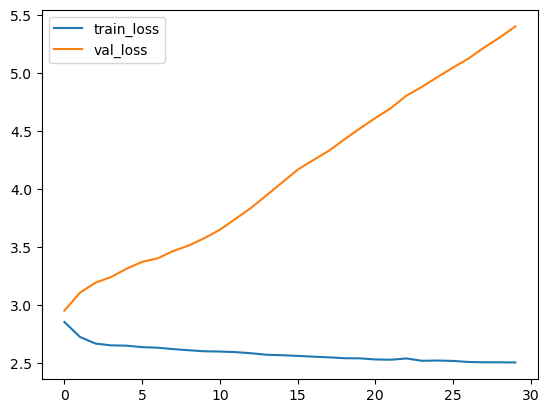

C:\Users\rlarn\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [40]:
EPOCHS = 30
BATCH_SIZE=8
def run_experiment():
    filepath = "./tmp/video_classifier.h5"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1)

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1], train_data[2], train_data[3]],  # 수정된 입력 데이터
        train_labels,
        batch_size=BATCH_SIZE,
        validation_split=0.2,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    
    _, accuracy = seq_model.evaluate(
        [test_data[0], test_data[1], test_data[2], test_data[3]],  # 수정된 입력 데이터
        test_labels
    )
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    # 손실 및 정확도 그래프 출력
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()
    
    seq_model.save('test_model.h5')
    
    return history, seq_model

_, sequence_model = run_experiment()

In [44]:
def prepare_single_video(frames, skeletons, hands):
    num_frames = frames.shape[1]
    video_length = min(MAX_SEQ_LENGTH, num_frames)

    frame_mask = np.zeros((1, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros((1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")
    frame_skeletons = np.zeros((1, MAX_SEQ_LENGTH, SKELETON_FEATURES), dtype="float32")
    frame_hands = np.zeros((1, MAX_SEQ_LENGTH, HAND_FEATURES), dtype="float32")
    frame_images = np.zeros((1, MAX_SEQ_LENGTH, IMG_SIZE, IMG_SIZE, 3), dtype="float32")
    
    feature_extractor = Sequential([
        ResNet50(include_top=False, weights='imagenet', pooling='avg'),  # 예시로 평균 풀링 사용
        Dense(NUM_FEATURES, activation='relu')  # NUM_FEATURES에 맞는 덴스 레이어 추가
    ])
    
    for j in range(video_length):
        # 이미지 데이터 전처리 및 특징 추출
        image_feature = preprocess_image(frames[j:j+1])
        image_feature = np.expand_dims(image_feature, axis=0)
        feature_result = feature_extractor.predict(image_feature)

        # frame_images 대신 feature_result를 사용
        frame_features[0, j] = feature_result

        # Mediapipe 데이터 전처리
        skeleton_feature = preprocess_skeleton_data(skeletons[j])
        hand_feature = preprocess_hand_data(hands[j])

        frame_skeletons[0, j] = skeleton_feature
        frame_hands[0, j] = hand_feature
        frame_mask[0, j] = 1

    return frame_features, frame_skeletons, frame_hands, frame_mask, frame_images

def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()
    frames, skeletons, hands = load_video(path)    
    try:
        num_frames = frames.shape[1]
    except IndexError:
        print("Error: Unable to determine the number of frames. Frames shape:", frames.shape)
        return None
    
    frame_features, frame_skeletons, frame_hands, frame_mask, frame_images = prepare_single_video(frames, skeletons, hands)
    probabilities = sequence_model.predict([frame_features, frame_skeletons, frame_hands, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"{class_vocab[i]} : {probabilities[i] * 100:5.2f}%")
    
    return frame_images

test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")

test_frames = sequence_prediction(test_video)

Test video path: E:/군순/train/NIA_SL_SEN1247/NIA_SL_SEN1247_REAL03_L.mp4
1/1 [==============================] - 3s 3s/step
NIA_SL_SEN1308 :  9.27%
NIA_SL_SEN1245 :  8.73%
NIA_SL_SEN1305 :  8.68%
NIA_SL_SEN1041 :  8.21%
NIA_SL_SEN1387 :  8.05%
NIA_SL_SEN1247 :  7.91%
NIA_SL_SEN1103 :  7.42%
NIA_SL_SEN1854 :  6.89%
NIA_SL_SEN1173 :  6.07%
NIA_SL_SEN1032 :  5.91%
NIA_SL_SEN1370 :  5.21%
NIA_SL_SEN1376 :  5.02%
NIA_SL_SEN1090 :  5.00%
NIA_SL_SEN1881 :  3.90%
NIA_SL_SEN1082 :  3.74%
